# Setup

### Find paths

In [1]:
repo_path = !git rev-parse --show-toplevel
assert (len(repo_path) == 1)

exec_path = repo_path[0] + "/benchmark_process_packet.exe"
exec_path

'/home/bm611/ebsl/benchmark_process_packet.exe'

### Run benchmark function

In [2]:
import numpy as np
import json

tasks = 50_000

def run(scheduler,domains=-1,spawners=-1):
    cmd = exec_path + " -scheduler " + scheduler + " -num-of-domains " + str(domains) + " -num-of-spawners " + str(spawners) + " -items-total " + str(tasks)
    print(cmd)
    output = !$cmd
    return json.loads(''.join(output))

In [3]:
def latency_undo_exp(x):
    return 1.2 ** x 

In [4]:
def find_percentile(array, percentile):
    assert (0 < percentile and percentile < 1)
    
    total = np.sum(array)
    
    percentile_boundary = percentile * total 
    current_total = 0
    for i in range(0,len(array)):
        current_total += array[i]
        if current_total > percentile_boundary:
            return i
    
    return "reached the end before finding percentile boundary"


def transform(parsed):
    time = [] 
    latency_half = []
    latency_threenine = []
    waited_for_space_on_enque = [] 
    latency = []
    latency_q10 = []
    latency_q25 = []
    latency_q50 = []
    latency_q99 = []
    latency_q999 = [] 
    latency_q9999 = []
    latency_q99999 = []

    for row in parsed['data']:
        if row['iteration'] == 1:
            continue

        time.append(row['time'])
        latency_half.append(latency_undo_exp(row['latency_median']))
        latency_threenine.append(latency_undo_exp(row['latency_three_nine']))
        waited_for_space_on_enque.append(row['waited-for-space-on-enque'])
        latency.append(row['latency'])
        
        latency_q50.append(latency_undo_exp(find_percentile(row['latency'], 0.5)))
        latency_q99.append(latency_undo_exp(find_percentile(row['latency'], 0.99)))
        latency_q999.append(latency_undo_exp(find_percentile(row['latency'], 0.999)))
        latency_q9999.append(latency_undo_exp(find_percentile(row['latency'], 0.9999)))
        latency_q99999.append(latency_undo_exp(find_percentile(row['latency'], 0.99999)))
                

    return {'time':time, 
            'waited_for_space_on_enque':waited_for_space_on_enque,
            'latency':latency,
            'latency_q50':latency_q50,
            'latency_q99':latency_q99,
            'latency_q999':latency_q999,
            'latency_q9999':latency_q9999,
            'latency_q99999':latency_q99999,
            'latency_half':latency_half,
            'median_latency_threenine':latency_threenine,
           }

In [5]:
def to_median_and_errs(array):
    median = np.median(array)
    lower_err = median - np.quantile(array, 0.25)
    upper_err = np.quantile(array, 0.75) - median
    return {'median': median, 'lower_err': lower_err, 'upper_err': upper_err}
    
def add_metrics(data):
    data['time-processed'] = to_median_and_errs(data['time'])
    data['latency_half-processed'] = to_median_and_errs(data['latency_half'])
    data['latency_threenine-processed'] = to_median_and_errs(data['median_latency_threenine'])
    data['waited_for_space_on_enque-processed'] = to_median_and_errs(data['waited_for_space_on_enque'])
    
    data['throughput-processed'] = to_median_and_errs((tasks * 1_000.)/np.array(data['time']))
    
    data['latency_q50-processed'] = to_median_and_errs(data['latency_q50'])
    data['latency_q99-processed'] = to_median_and_errs(data['latency_q99'])
    data['latency_q999-processed'] = to_median_and_errs(data['latency_q999'])
    data['latency_q9999-processed'] = to_median_and_errs(data['latency_q9999'])
    data['latency_q99999-processed'] = to_median_and_errs(data['latency_q99999'])
    
    

### Find percentiles function

### Plotting

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

# Experiment 1: simple workload, skewed

## Data collection

In [64]:
param_space = range(5,120,5)

fifo = []
for i in param_space:
    fifo.append(run("FIFO", domains=i, spawners=min(4, int(i/2))))

lifo = []
for i in param_space:
    lifo.append(run("LIFO", domains=i, spawners=min(4, int(i/2))))
    
x = list(param_space)

/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 5 -num-of-spawners 2 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 10 -num-of-spawners 4 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 15 -num-of-spawners 4 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 20 -num-of-spawners 4 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 25 -num-of-spawners 4 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 30 -num-of-spawners 4 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 35 -num-of-spawners 4 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 40 -num-of-spawners 4 -items-total 50000
/home/bm611/ebsl/benchmark_process_packet.exe -sc

In [65]:
run_name = "2spawners"

In [66]:
import pickle


with open('packet_fifo_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(fifo, handle)
    

with open('packet_lifo_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(lifo, handle)


In [67]:
fifo_transformed = []
for row in fifo:
    fifo_transformed.append(transform(row))
    
lifo_transformed = []
for row in lifo:
    lifo_transformed.append(transform(row))

In [68]:
for row in fifo_transformed:
    add_metrics(row)
for row in lifo_transformed:
    add_metrics(row)


## Analysis

### Exec time vs number of domains

In [69]:
def to_series(data, label):
    return [v[label]["median"] for v in data]

In [70]:
def plot(x, data, key, name):
    y = [v[key]["median"] for v in data]
    lower_errbar = [v[key]["lower_err"] for v in data]
    upper_errbar = [v[key]["upper_err"] for v in data]
    
    return ax.errorbar(x, y, [lower_errbar, upper_errbar], label=name)
    

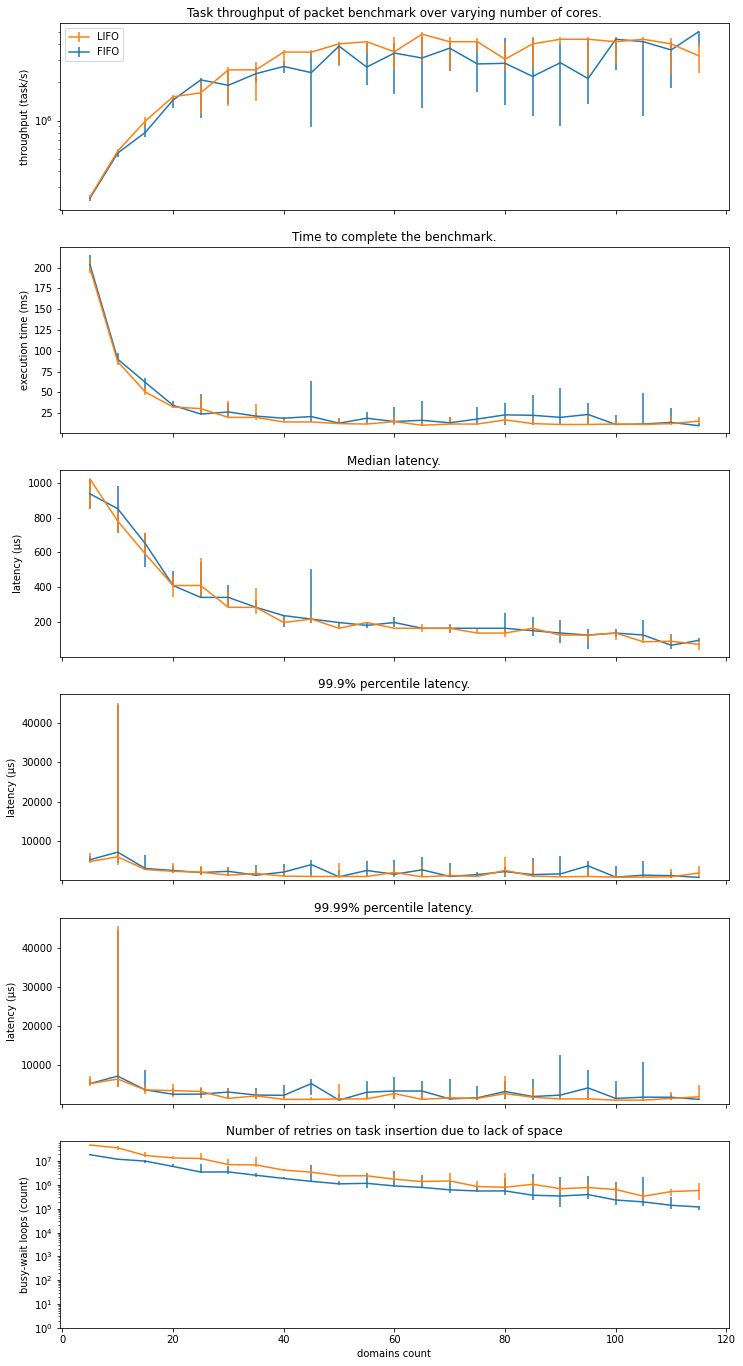

In [71]:
size = 6

fig, axes = plt.subplots(size, 1, sharex=True)
fig.set_size_inches(12, 4 * size)


ax = axes[0]

#line_lifo, = ax.plot(x, to_series(fifo_transformed, "time-processed"), label='FIFO')
#line_fifo, = ax.plot(x, to_series(lifo_transformed, "time-processed"), label='LIFO')

line_lifo = plot(x, fifo_transformed, "throughput-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "throughput-processed", 'LIFO')

ax.legend(handles=[line_fifo, line_lifo])

ax.set_yscale("log")
#ax.set_ylim(ymin=1)
ax.set_title("Task throughput of packet benchmark over varying number of cores.") 
ax.set_ylabel('throughput (task/s)')

########################
## TIME ################
########################
ax = axes[1]
#line_lifo, = ax.plot(x, to_series(fifo_transformed, "time-processed"), label='FIFO')
#line_fifo, = ax.plot(x, to_series(lifo_transformed, "time-processed"), label='LIFO')

line_lifo = plot(x, fifo_transformed, "time-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "time-processed", 'LIFO')

ax.set_ylim(ymin=1)
ax.set_title("Time to complete the benchmark.") 
ax.set_ylabel('execution time (ms)')


########################
## MEDIAN LATENCY ######
########################

ax = axes[2]


line_lifo = plot(x, fifo_transformed, "latency_q50-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q50-processed", 'LIFO')


#ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_ylabel('latency (μs)')
ax.set_title("Median latency.") 

########################
## Q99 LATENCY ######
########################

ax = axes[3]


line_lifo = plot(x, fifo_transformed, "latency_q999-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q999-processed", 'LIFO')

#ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_ylabel('latency (μs)')
ax.set_title("99.9% percentile latency.") 


########################
## Q99.9 LATENCY ######
########################

ax = axes[4]


line_lifo = plot(x, fifo_transformed, "latency_q9999-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q9999-processed", 'LIFO')

#ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_ylabel('latency (μs)')
ax.set_title("99.99% percentile latency.") 

########################
## WAIT ################
########################

ax = axes[5]


line_lifo = plot(x, fifo_transformed, "waited_for_space_on_enque-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "waited_for_space_on_enque-processed", 'LIFO')

ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_xlabel('domains count')
ax.set_ylabel('busy-wait loops (count)')
ax.set_title("Number of retries on task insertion due to lack of space") 

ax.set_xlabel('domains count')


plt.savefig("packet-basic-" + run_name + ".png", dpi=200)